In [1]:
from PIL import Image
import torch
import numpy as np

from IPython.display import display
from scipy.ndimage import zoom

def show_tensor_image(img):
    scale = 512/(img.shape[1]*img.shape[2])**0.5
    img = torch.clip(img, 0.0, 1.0).permute(1, 2, 0).cpu().numpy()
    img = (255*zoom(img, (scale, scale, 1))).astype(np.uint8)
    pil_image = Image.fromarray(img)
    display(pil_image)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

import sys, os
depth_anything_path = "/home/harry7557558/GitHub/external/Depth-Anything/"
sys.path += [depth_anything_path]
current_directory = os.getcwd()
os.chdir(depth_anything_path)

from depth_anything.dpt import DepthAnything

encoder = 'vits' # can also be 'vitb' or 'vitl'
model = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder))
model = model.to(device)

os.chdir(current_directory)

# print(model)

xFormers not available
xFormers not available


In [2]:
# image_filename = "/media/harry7557558/OS/Archive/DCIM/20240321_193228.jpg"
# image_filename = "/home/harry7557558/nerd-face_1f913.png"
# image_filename = "/home/harry7557558/GitHub/miscellaneous/discord/attachments/1268336112821080127-20240731_181336.jpg"
# image_filename = "/home/harry7557558/GitHub/miscellaneous/discord/attachments/1268336113509204030-20240731_181427.jpg"
# image_filename = "/home/harry7557558/GitHub/miscellaneous/discord/attachments/1268336113957736448-20240731_181508.jpg"
image_filename = "/home/harry7557558/GitHub/miscellaneous/discord/attachments/1268336114461315113-20240731_181526.jpg"
# image_filename = "/home/harry7557558/GitHub/miscellaneous/discord/attachments/1268336114985599009-20240731_181604.jpg"
# image_filename = "/media/harry7557558/OS/Archive/DCIM/20231210_225503.jpg"
# image_filename = "/media/harry7557558/OS/Archive/DCIM/20230905_202135.jpg"

img = Image.open(image_filename)

from PIL import ExifTags
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation]=='Orientation':
        break
if hasattr(img, '_getexif'):
    exif = img._getexif()
    if exif is not None and orientation in exif:
        print("exif orientation:", exif[orientation])
        if exif[orientation] == 3:
            img=img.rotate(180, expand=True)
        elif exif[orientation] == 6:
            img=img.rotate(270, expand=True)
        elif exif[orientation] == 8:
            img=img.rotate(90, expand=True)

x = img.convert("RGB")
scale = 1024/(x.width*x.height)**0.5
w = int(x.width*scale/14+0.5)*14
h = int(x.height*scale/14+0.5)*14
x = x.resize((w, h), Image.LANCZOS)

print("Image size:", x.size)

x = np.array(x, dtype=np.float32) / 255.0
x = np.transpose(x, (2, 0, 1))

from time import perf_counter
with torch.no_grad():
    time0 = perf_counter()
    
    mu = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((3, 1, 1))
    sigma = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((3, 1, 1))
    xc = torch.tensor((x-mu)/sigma, device=device).unsqueeze(0)
    y = model(xc)[0].cpu().numpy()

    time1 = perf_counter()
    print(1000*(time1-time0), 'ms')


Image size: (1176, 882)
722.6357059989823 ms


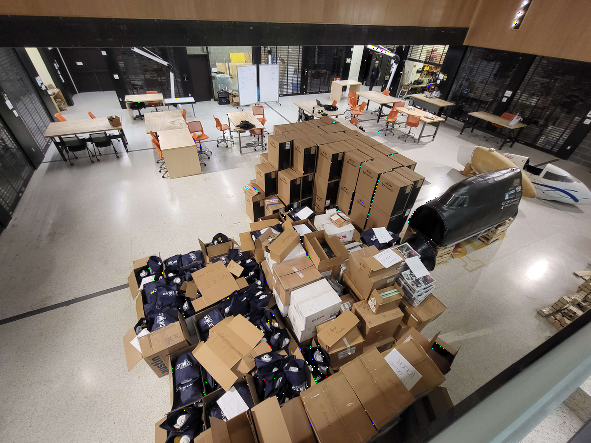

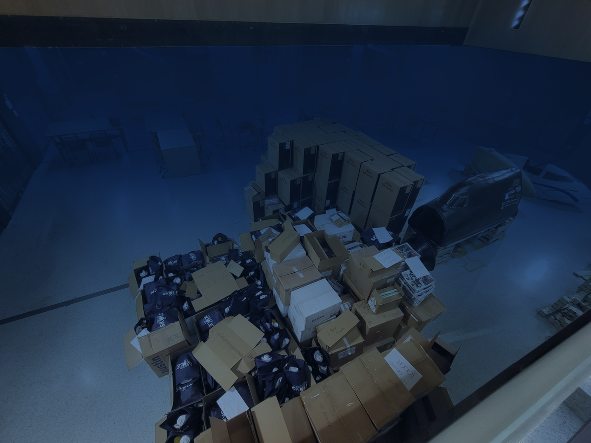

In [3]:

x = torch.tensor(x)
y = torch.tensor(y)

m = 0.5*(torch.amin(y)+torch.amax(y))
y1 = -(y-m)+m

y1 = 1.0/(y+1.0)
y1 = 3.0 * (y1-torch.amin(y1)) / (torch.amax(y1)-torch.amin(y1)) + 0.1
# y1 = 5.0 * y1 / torch.amax(y1)

y1 = y1.unsqueeze(0)

col = torch.tensor([0.1, 0.25, 0.5]).reshape(3, 1, 1)

c = x*torch.pow(col, y1)
c = c + (0.5*col-c) * (1.0-torch.exp(-y1))

show_tensor_image(x)
show_tensor_image(c)

In [4]:
from plyfile import PlyData, PlyElement

def write_ply(rgb_array, depth_array, file_path):
    h, w = depth_array.shape
    num_points = w * h

    # Flatten arrays
    depth_flat = depth_array.flatten()
    # depth_flat = 1.0 / (depth_flat + 0.1)
    depth_flat = -depth_flat + np.amax(depth_flat)
    depth_flat /= np.mean(depth_flat)
    rgb_flat = rgb_array.reshape((3, -1)).T

    # Create vertex data
    vertex = np.zeros(num_points, dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), 
                                         ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])
    vertex['x'] = np.tile(np.arange(w), h) / (w*h)**0.5
    vertex['y'] = w - np.repeat(np.arange(h), w) / (w*h)**0.5
    # vertex['z'] = depth_flat / (2.5*np.std(depth_flat))
    vertex['z'] = depth_flat
    z_rel = depth_flat + 1.0
    print(np.amin(z_rel), np.amax(z_rel))
    f_rel = 0.8
    vertex['x'] = -(vertex['x'] - np.mean(vertex['x'])) * z_rel * f_rel
    vertex['y'] = (vertex['y'] - np.mean(vertex['y'])) * z_rel * f_rel
    rgb = (np.clip(rgb_flat,0,1)*255+0.5).astype(np.uint8)
    vertex['red'] = rgb[:, 0]
    vertex['green'] = rgb[:, 1]
    vertex['blue'] = rgb[:, 2]

    faces = []
    depth = vertex['z']
    print(depth.shape)
    for y in range(h - 1):
        for x in range(w - 1):
            i00 = y * w + x
            i10 = i00 + 1
            i01 = (y + 1) * w + x
            i11 = i01 + 1
            gx = depth[i01]+depth[i11]-depth[i00]-depth[i10]
            gy = depth[i10]+depth[i11]-depth[i00]-depth[i01]
            if np.hypot(gx, gy) < 20 / (w*h)**0.5:
                faces.append(([i00, i10, i11, i01], 0))

    faces = np.array(faces,
                     dtype=[('vertex_indices', 'i4', (4,)), ('i', 'u1')])

    # Create PlyElements
    vertex_element = PlyElement.describe(vertex, 'vertex')
    face_element = PlyElement.describe(faces, 'face')

    # Write to PLY file
    ply_data = PlyData([vertex_element, face_element])
    ply_data.write(file_path)


scale = 384/(x.shape[1]*x.shape[2])**0.5
print(torch.amin(y), torch.amax(y))
write_ply(
    zoom(x, (1, scale, scale)),
    zoom(y, (scale, scale)),
    "depth_mesh.ply")


tensor(0.1590) tensor(28.2262)
1.0 2.3237882
(147519,)
